# Clase 12: Redes neuronales artificiales

In [41]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [42]:
class Perceptron(object):

    def __init__(self, n_signals, n_epoch = 100, t_aprendizaje = 0.01):
        self.n_epoch = n_epoch
        # Tasa de aprendizaje, que tan rápido queremos actualizar nuestros pesos
        self.t_aprendizaje = t_aprendizaje
        # Definir pesos iniciales, las señales más un 1 que es el intercepto o sesgo
        self.weights = np.zeros(n_signals + 1)

    def predict(self, inputs):
        # se define la suma de todo el predictor lineal para una fila
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        # Función de activación, la más simple el hardlimit, si mayor a cero, uno; en otro caso cero
        if summation > 0:
          activation = 1
        else:
          activation = 0            
        return activation

    def train(self, inputs, labels):
        for _ in range(self.n_epoch):
            # Esto es solo para indicar al usuario en que estado va
            if(_ % 10 == 0):
                print("Trainning.. Epoch: " + str(_))
            # Recorrer uno a uno cada input y label
            for i, l in zip(inputs, labels):
                # Predecimos con los pesos iniciales
                prediction = self.predict(i)
                # Actualizamos los pesos de acuerdo a una función de perdida (predicción menos label).
                # En caso de estar correcto, se queda el peso actual, caso contrario se va cambiando
                self.weights[1:] = self.weights[1:] + self.t_aprendizaje * (l - prediction) * i
                self.weights[0] = self.weights[0] + self.t_aprendizaje * (l - prediction)        
        
    def scoring(self, new_inputs):
        self.preds = []
        for i in zip(new_inputs):
            self.preds.append(self.predict(i))

Vamos a cargar datos de imágenes de ropa para validar esto. Estas son imágenes en escala de grises de 28$\times$28 pixeles, en las que aparecen distintos tipo de prendas, en particular

0. Poleras
1. Pantalones
2. Sudadera
3. Vestido
4. Chaqueta
5. Sandalia
6. Camisa
7. Sneaker
8. Bolsa
9. Bota 

Aquí el problema es a partir de una imagen simple, distinguir que es por ejemplo una polera.
https://www.kaggle.com/zalando-research/fashionmnist

In [43]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

In [44]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


para que se entienda, vamos a colorear la fila 3 como imagen

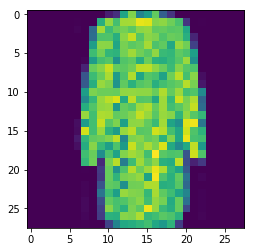

In [45]:
polera = np.matrix(train.loc[200, ][1:]).reshape(28,28)
plt.imshow(polera)

En problemas como estos, metodologías poco interpretables hacen sentido, buscamos encontrar el pratrón de un conjunto de variables que no nos dicen nada. La data ya está balanceada, pero tomaremos todas las poleras contra una muestra del mismo tamaño de cualquier otra cosa


In [47]:
train_p = train[train.label == 0]
train_np = train[train.label != 0].sample(train_p.shape[0])
train_n = (pd.concat([train_p, train_np]).
          assign(label = lambda x: (x.label == 0) * 1))

In [16]:
X = np.matrix(train_n.iloc[:,1:785])
y = np.matrix(train_n['label'])

perc = Perceptron(n_signals = 784, n_epoch = 200, t_aprendizaje = 0.5)
fit = perc.train(X, np.ravel(y))

Trainning.. Epoch: 0
Trainning.. Epoch: 10
Trainning.. Epoch: 20
Trainning.. Epoch: 30
Trainning.. Epoch: 40
Trainning.. Epoch: 50
Trainning.. Epoch: 60
Trainning.. Epoch: 70
Trainning.. Epoch: 80
Trainning.. Epoch: 90
Trainning.. Epoch: 100
Trainning.. Epoch: 110
Trainning.. Epoch: 120
Trainning.. Epoch: 130
Trainning.. Epoch: 140
Trainning.. Epoch: 150
Trainning.. Epoch: 160
Trainning.. Epoch: 170
Trainning.. Epoch: 180
Trainning.. Epoch: 190


Dado que tenemos los pesos, podemos scorear la nueva data

In [48]:
test_p = test[test.label == 0]
test_np = test[test.label != 0].sample(1000)
test_n = (pd.concat([test_p, test_np]).
          assign(label = lambda x: (x.label == 0) * 1))

In [49]:
X_te = np.matrix(test_n.iloc[:,1:785])
y_te = np.matrix(test_n['label'])
perc.scoring(X_te)
preds = np.array(perc.preds)
print(confusion_matrix(y_te.T, preds))
print(accuracy_score(y_te.T, preds))

[[997   3]
 [989  11]]
0.504


## Uso de pytorch

Pytorch para las computaciones hace uso de una estructura llamada tensor, en escencia un tensor es un arreglo como los de numpy, pero tiene ventajas como la capacidad de ser distribuido de forma más sencilla; tienen la capacidad de ser distribuidos en una GPU lo cual permite acelerar los cómputos. Hoy usaremos CPU la cual puede ser un poco más lenta.

In [28]:
import torch

dtype = torch.float
device = torch.device("cpu")

Un tensor se puede construir especificando las dimensiones del mismo

In [29]:
torch.empty(5, 5)

tensor([[1.0102e-38, 5.9694e-39, 8.9082e-39, 1.0194e-38, 9.1837e-39],
        [4.6837e-39, 9.9184e-39, 9.0000e-39, 1.0561e-38, 1.0653e-38],
        [4.1327e-39, 8.9082e-39, 9.8265e-39, 9.4592e-39, 1.0561e-38],
        [1.0653e-38, 1.0469e-38, 9.5510e-39, 8.7245e-39, 1.0286e-38],
        [9.0919e-39, 9.0919e-39, 9.2755e-39, 8.7245e-39, 8.7245e-39]])

In [30]:
torch.empty(2, 2, 2, 2)

tensor([[[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]]])

O bien si se desea con ceros

In [31]:
torch.zeros(5, 5)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

También puedes construirlos a partir de otro tensor, esto resulta útil para "reciclar" las propiedades del tensor anterior

In [32]:
t = torch.zeros(5, 5)
torch.rand_like(t)

tensor([[0.4269, 0.0801, 0.5533, 0.7474, 0.7992],
        [0.7795, 0.4499, 0.3900, 0.9425, 0.0812],
        [0.5940, 0.7518, 0.2709, 0.7906, 0.7945],
        [0.4585, 0.1638, 0.5845, 0.5289, 0.8291],
        [0.5642, 0.6720, 0.4618, 0.0550, 0.2076]])

Las operaciones son similares a las de numpy

In [33]:
s = torch.empty(5, 5)

In [34]:
print(s + t)
print(s * t)
print(t.size())

tensor([[-6.8695e-22,  7.7212e-43,  1.4013e-45,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  2.1019e-44,  0.0000e+00, -2.7867e-17,  7.7212e-43],
        [ 1.4013e-45,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.1019e-44],
        [ 0.0000e+00, -3.1646e-27,  7.7212e-43,  1.4013e-45,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  2.1019e-44,  0.0000e+00, -1.8157e-19]])
tensor([[-0., 0., 0., 0., 0.],
        [0., 0., 0., -0., 0.],
        [0., 0., 0., 0., 0.],
        [0., -0., 0., 0., 0.],
        [0., 0., 0., 0., -0.]])
torch.Size([5, 5])


Los tensores pueden ser convertidos a arreglos de numpy y viceversa de forma bien directa.

In [35]:
s = t.numpy()
print(s)
s = torch.from_numpy(s)
print(s)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


Los tensores se les puede definir en que hardware correr, por defecto es la CPU pero se les puede definir que corran en GPU con la opción ```device```. 

Pytorch funciona sobre un grafo computacional, es decir un registro de todas las historias de las operaciones que va recibiendo los tensores, para y haciendo este seguimiento se aplica si se usa la especificación ```requieres_grad```

In [36]:
x = torch.ones(3, 3, requires_grad=True)
x2 = x + 1
print(x2)

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]], grad_fn=<AddBackward0>)


In [37]:
x2.grad_fn

Dado que existe un seguimiento, pytorch tiene la capacidad de obtener los gradientes, por ejemplo acá se hace una función mátemática a los tensores. 

In [38]:
z = x2 * x2 * 2
out = z.mean()

print(out)

tensor(8., grad_fn=<MeanBackward0>)


Para calcular derivadas, se requiere hacer la operación backward primero, esto es para aplicar una metodología llamada **retropropagación** para el cálculo de gradientes

In [39]:
out.backward()

In [40]:
print(x.grad)

tensor([[0.8889, 0.8889, 0.8889],
        [0.8889, 0.8889, 0.8889],
        [0.8889, 0.8889, 0.8889]])


Para ir entendiendo el resultado, se hicieron tres operaciones, a $x$ se sumo 1, luego se elevó al cuadrado y se multiplicó por dos, por último se obtuvo el promedio, es decir

$$out = \frac{1}{9}\sum_{i = 1}^{9} 2(x_i + 1)^2$$

Si esto se deriva con respecto a $x_{ij}$ se obtiene que para cada elemento de la matriz es

$$\dfrac{\partial~ out}{\partial x_i} = \frac{4}{9} (x_i + 1) $$

Si se evalúa en $x_i$, los cuales eran todos unos, da $8/9$, es decir el resultado que nos muestra. Esto es bastante poderoso pues nos permite definir todo el flujo de operaciones y obtener un gradiente en un momento específico.

En términos más generales, si nuestro out es un vector lo que se obteniene es el jacobiano diferenciando con respecto a los elementos de x


$$\begin{split}J=\left(\begin{array}{ccc}
 \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
 \vdots & \ddots & \vdots\\
 \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
 \end{array}\right)\end{split}$$


El proceso típico para construir una red neuronal es

- Definir la red con parámetros aprendibles (pesos)
- Iterar sobre la data de input
- Procesar el input por la red
- Calcular la pérdida
- Obtener los gradientes
- Actualizar los pesos de la red por gradiente descendente

En pytorch una red se define como una clase, esta tiene como constructor la estructura de la red (capas ocultas, capas especiales, etc), aquí se deben especificar también la cantidad de neuronas. Por ejemplo vamos a definir una red con dos capas ocultas.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class my_primera_red(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True) 
        self.lin2 = nn.Linear(50, 20, bias=True)
        self.lin3 = nn.Linear(20, 8, bias=True)

Se define dentro de la misma clase la función ```forward```, la cual indica las operaciones para pasar de capa en capa, es decir las funciones de activación, además se le debe entregar la data de input.

In [22]:
class mi_primera_red(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 128, bias=True) 
        self.lin2 = nn.Linear(128, 64, bias=True)
        self.lin3 = nn.Linear(64, 2, bias=True)

    def forward(self, xb):
        # Adaptar la forma para que entre en el input layer
        x = xb.view(-1,784) 
        # Se aplica relu como función de activación
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin3(x)

Definamos la función de pérdida y el mecanismo de optimización. La función de pérdida es la entropía cruzada y vamos a optimizar por gradiente descendente estocástico (SGD)

In [24]:
import torch.optim as optim

mi_red = mi_primera_red()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mi_red.parameters(), lr=0.001)

Ahora queda cargar la data

In [28]:
from torch.autograd import Variable

train_X = Variable(torch.Tensor(X).float())
test_X = Variable(torch.Tensor(X_te).float())
train_y = Variable(torch.Tensor(np.array(y)[0].astype('int8')).long())
test_y = Variable(torch.Tensor(np.array(y_te)[0].astype('int8')).long())

In [29]:
for epoch in range(200):
    optimizer.zero_grad()
    out = mi_red(train_X)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch actual: ' + str(epoch) + ' , Pérdida: ' + str(np.array(loss.data)))

Epoch actual: 0 , Pérdida: 3.9542239
Epoch actual: 10 , Pérdida: 0.32088122
Epoch actual: 20 , Pérdida: 0.27094322
Epoch actual: 30 , Pérdida: 0.25015005
Epoch actual: 40 , Pérdida: 0.23835354
Epoch actual: 50 , Pérdida: 0.22985666
Epoch actual: 60 , Pérdida: 0.2232973
Epoch actual: 70 , Pérdida: 0.2177188
Epoch actual: 80 , Pérdida: 0.21294057
Epoch actual: 90 , Pérdida: 0.20884198
Epoch actual: 100 , Pérdida: 0.20523071
Epoch actual: 110 , Pérdida: 0.20199792
Epoch actual: 120 , Pérdida: 0.19910014
Epoch actual: 130 , Pérdida: 0.19644055
Epoch actual: 140 , Pérdida: 0.19402616
Epoch actual: 150 , Pérdida: 0.19180036
Epoch actual: 160 , Pérdida: 0.18967219
Epoch actual: 170 , Pérdida: 0.1876939
Epoch actual: 180 , Pérdida: 0.1858324
Epoch actual: 190 , Pérdida: 0.18400374


In [30]:
predict_out = mi_red(test_X) 
_, predict_y = torch.max(predict_out, 1)
accuracy_score(test_y.data, predict_y.data)

0.9335

Veamos que tal el train

In [33]:
predict_out = mi_red(train_X) 
_, predict_y = torch.max(predict_out, 1)
accuracy_score(train_y.data, predict_y.data)

0.9335

El sobreajuste se puede controlar reduciendo la complejidad de la arquitectura de redes, o bien aplicando una operación llamada dropout, la cual consiste en eliminar neuronas al azar.

## Redes convolucionales

Pytorch facilita la creación de estas redes, pues ya tiene capas definidas que hacen este trabajo.

In [34]:
class mi_segunda_red(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 4, stride = 1)
#        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 6, kernel_size = 4)
        self.lin1 = nn.Linear(720, 600, bias = True) 
        self.lin2 = nn.Linear(600, 256, bias = True)
        self.lin3 = nn.Linear(256, 2, bias = True)

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features        
    
    def forward(self, x):
        # Se especifica la operación de pooling, en este caso el máximo, se hará sobre una ventana de 4 por 4
        x = F.max_pool2d(F.relu(self.conv1(x)), (4, 4))
#        x = F.max_pool2d(F.relu(self.conv2(x)), (3, 3))
        # Definir algo más variable en caso que las arquitecturas vayan variando
        x = x.view(-1, self.num_flat_features(x)) 
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin3(x)

In [35]:
mi_red2 = mi_segunda_red()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mi_red2.parameters(), lr = 0.15)
# Dar formato de grilla a la data de entrenamiento
X_grid_train = torch.reshape(train_X, (12000, 1, 28, 28))

In [36]:
for epoch in range(200):
    optimizer.zero_grad()
    out = mi_red2((X_grid_train - 128) / 255)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch actual: ' + str(epoch) + ' , Pérdida: ' + str(np.array(loss.data)))

Epoch actual: 0 , Pérdida: 0.69408983
Epoch actual: 10 , Pérdida: 0.6350261
Epoch actual: 20 , Pérdida: 0.47324303
Epoch actual: 30 , Pérdida: 0.29712325
Epoch actual: 40 , Pérdida: 0.28414226
Epoch actual: 50 , Pérdida: 0.23176147
Epoch actual: 60 , Pérdida: 0.30280262
Epoch actual: 70 , Pérdida: 0.22752509
Epoch actual: 80 , Pérdida: 0.21075657
Epoch actual: 90 , Pérdida: 0.20413359
Epoch actual: 100 , Pérdida: 0.19930078
Epoch actual: 110 , Pérdida: 0.19534326
Epoch actual: 120 , Pérdida: 0.19199033
Epoch actual: 130 , Pérdida: 0.1924883
Epoch actual: 140 , Pérdida: 0.24191272
Epoch actual: 150 , Pérdida: 0.18680601
Epoch actual: 160 , Pérdida: 0.18396086
Epoch actual: 170 , Pérdida: 0.18183936
Epoch actual: 180 , Pérdida: 0.18099752
Epoch actual: 190 , Pérdida: 0.2035322


In [37]:
predict_out = mi_red2((X_grid_train - 128) / 255) 
_, predict_y = torch.max(predict_out, 1)
accuracy_score(train_y.data, predict_y.data)

0.9293333333333333

In [41]:
# Dar formato de grilla a la data de test
X_grid_test = torch.reshape(test_X, (2000, 1, 28, 28))
predict_out = mi_red2((X_grid_test - 128) / 255) 
_, predict_y = torch.max(predict_out, 1)
accuracy_score(test_y.data, predict_y.data)

0.927

In [42]:
preds = np.array(predict_y.data)

In [52]:
# Reales
print(preds[1000:1020])
# Falsos positivo
print(preds[1205])
print(preds[1204])
# Falsos negativos
print(preds[9])

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
0
0
0


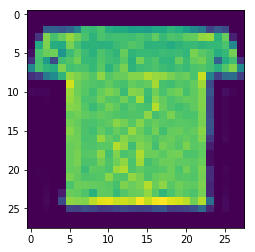

In [53]:
plt.imshow(np.matrix(np.array(X_grid_test.data)[1008]).reshape(28,28))

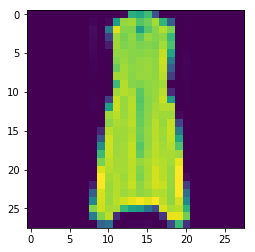

In [47]:
plt.imshow(np.matrix(np.array(X_grid_test.data)[1204]).reshape(28,28))

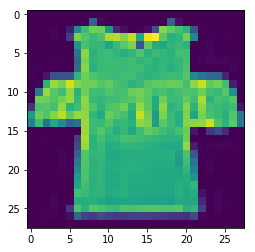

In [53]:
plt.imshow(np.matrix(np.array(X_grid_test.data)[1205]).reshape(28,28))

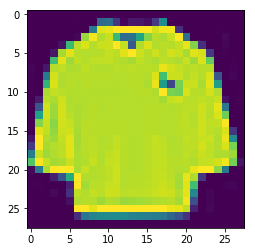

In [56]:
plt.imshow(np.matrix(np.array(X_grid_test.data)[9]).reshape(28,28))